In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import Row
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import warnings

#import custom class
from Classes.Mysql_class import Mysql_Class
#import custom help functions
from Help_Functions.Functions import avg_silhouette_scores,plot_avg_silhouette_scores,sse_calculation,plot_kneelocator

In [2]:
pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

# MYSQL CONNECTION 

In [3]:
# credentials and connection using mysql class developed
mysql_init=Mysql_Class(user = "",
                    host = "",
                    password = "")
engine = mysql_init.create_engine("")
# query mysql database to dataframe
query = """SELECT * FROM FactInternetSales
        LEFT JOIN DimCustomer ON FactInternetSales.CustomerKey = DimCustomer.CustomerKey
        LEFT JOIN DimGeography ON DimCustomer.GeographyKey = DimGeography.GeographyKey
        LEFT JOIN DimProduct ON FactInternetSales.ProductKey = DimProduct.ProductKey
        LEFT JOIN DimCurrency ON FactInternetSales.CurrencyKey = DimCurrency.CurrencyKey
        LEFT JOIN DimSalesTerritory ON FactInternetSales.SalesTerritoryKey = DimSalesTerritory.SalesTerritoryKey"""
merged_df = pd.read_sql_query(query, engine)

In [3]:
###-------->>>>>  EXECUTE THIS LINE IF YOU DONT HAVE TABLES UPLOADED ON MYSQL <<<<---------
merged_df=pd.read_csv("Data/Merged_dataframes/FactInternetSales_querry.csv")

# DROP COLUMNS

In [6]:
#len dataframe
len(merged_df)

60398

In [7]:
# columns
merged_df.columns

Index(['ProductKey', 'OrderDateKey', 'DueDateKey', 'ShipDateKey',
       'CustomerKey', 'PromotionKey', 'CurrencyKey', 'SalesTerritoryKey',
       'SalesOrderNumber', 'SalesOrderLineNumber',
       ...
       'EndDate', 'Status', 'CurrencyKey', 'CurrencyAlternateKey',
       'CurrencyName', 'SalesTerritoryKey', 'SalesTerritoryAlternateKey',
       'SalesTerritoryRegion', 'SalesTerritoryCountry', 'SalesTerritoryGroup'],
      dtype='object', length=101)

In [8]:
#drop columns
merged_df.drop(['ProductKey', 
                'OrderDateKey', 
                'DueDateKey', 
                'ShipDateKey', 
                'PromotionKey', 
                'SalesTerritoryKey',
                'SalesOrderNumber', 
                'SalesOrderLineNumber', 
                'RevisionNumber','UnitPrice', 'ExtendedAmount', 'UnitPriceDiscountPct',
       'DiscountAmount', 'ProductStandardCost', 
                'TotalProductCost',
                # 'SalesAmount',
               'TaxAmt', 'Freight', 'CarrierTrackingNumber',
       'CustomerPONumber',], axis=1, inplace=True)

In [9]:
# Identify duplicate column names
duplicates =merged_df.columns[merged_df.columns.duplicated()]
# Drop the duplicates, keep the first occurrence
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

In [10]:
merged_df.columns

Index(['CustomerKey', 'CurrencyKey', 'OrderQuantity', 'SalesAmount',
       'OrderDate', 'DueDate', 'ShipDate', 'GeographyKey',
       'CustomerAlternateKey', 'Title', 'FirstName', 'MiddleName', 'LastName',
       'NameStyle', 'BirthDate', 'MaritalStatus', 'Suffix', 'Gender',
       'EmailAddress', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome',
       'EnglishEducation', 'SpanishEducation', 'FrenchEducation',
       'EnglishOccupation', 'SpanishOccupation', 'FrenchOccupation',
       'HouseOwnerFlag', 'NumberCarsOwned', 'AddressLine1', 'AddressLine2',
       'Phone', 'DateFirstPurchase', 'CommuteDistance', 'City',
       'StateProvinceCode', 'StateProvinceName', 'CountryRegionCode',
       'EnglishCountryRegionName', 'SpanishCountryRegionName',
       'FrenchCountryRegionName', 'PostalCode', 'IpAddressLocator',
       'ProductAlternateKey', 'ProductSubcategoryKey', 'WeightUnitMeasureCode',
       'SizeUnitMeasureCode', 'EnglishProductName', 'SpanishProductName',
       'Frenc

In [11]:
merged_df.drop(['DueDate','ShipDate', 'GeographyKey', 'CustomerAlternateKey', 'Title','MiddleName','NameStyle', 'Suffix','EmailAddress', 'NumberChildrenAtHome','SpanishEducation', 'FrenchEducation',
       'SpanishOccupation', 'FrenchOccupation', 'HouseOwnerFlag',
       'NumberCarsOwned', 'AddressLine1', 'AddressLine2', 'Phone',
       'DateFirstPurchase', 'CommuteDistance', 'ProductAlternateKey',
       'ProductSubcategoryKey', 'WeightUnitMeasureCode', 'SizeUnitMeasureCode',
               'SpanishProductName', 'FrenchProductName',
       'StandardCost', 'FinishedGoodsFlag', 'Color', 'SafetyStockLevel',
       'ReorderPoint', 'ListPrice', 'Size', 'SizeRange', 'Weight',
       'DaysToManufacture', 'ProductLine', 'DealerPrice', 'Class', 'Style',
       'ModelName', 'EnglishDescription', 'StartDate', 'EndDate', 'Status',
       'CurrencyAlternateKey','City', 'StateProvinceCode', 'CountryRegionCode','SpanishCountryRegionName', 'FrenchCountryRegionName', 'PostalCode',
       'IpAddressLocator'], axis=1, inplace=True)

# DATA ANALYSIS

#### Numeric Cols

In [12]:
num_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns

In [13]:
num_cols

Index(['CustomerKey', 'CurrencyKey', 'OrderQuantity', 'SalesAmount',
       'YearlyIncome', 'TotalChildren', 'SalesTerritoryAlternateKey'],
      dtype='object')

In [14]:
# Unique number of customers
merged_df['CustomerKey'].nunique()

18484

In [15]:
# merged_df['TotalProductCost'].describe()
merged_df['YearlyIncome'].describe()

count     60398.000000
mean      59715.056790
std       33065.426837
min       10000.000000
25%       30000.000000
50%       60000.000000
75%       80000.000000
max      170000.000000
Name: YearlyIncome, dtype: float64

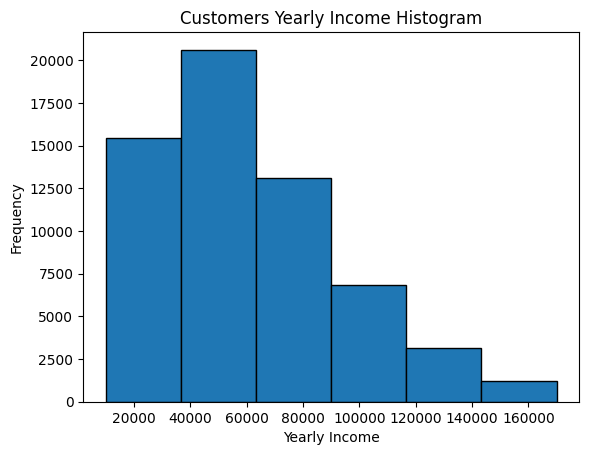

In [16]:
# Yearly Income Histogram
plt.hist(merged_df['YearlyIncome'], bins=6, edgecolor='black')
plt.xlabel('Yearly Income')
plt.ylabel('Frequency')
plt.title('Customers Yearly Income Histogram')
plt.show()

In [17]:
# Yearly Income Box Plot
fig = px.box(merged_df,
              y="YearlyIncome",
             template="plotly_white",
             
                width=1000,
              height=500, 
            
             color_discrete_sequence=['green']
             )

fig.update_layout(
title_text="Customers Yearly Income Box Plot",
title_font_size=20,
title_x=0.5,
yaxis_title="Yearly Income",
)
fig.show()

In [18]:
# Sales Amount Describe
merged_df['SalesAmount'].describe()

count    60398.000000
mean       486.086911
std        928.489892
min          2.290000
25%          7.950000
50%         29.990000
75%        539.990000
max       3578.270000
Name: SalesAmount, dtype: float64

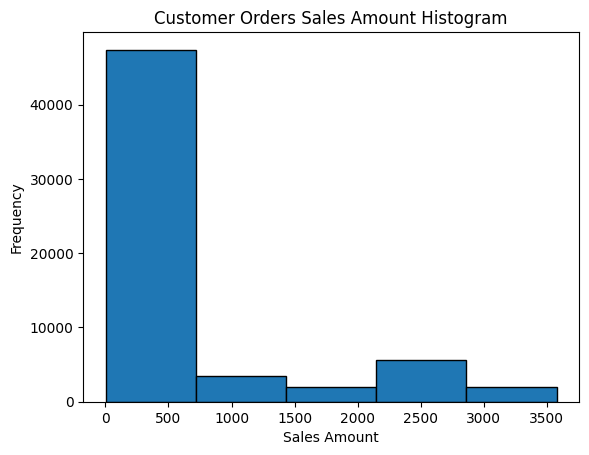

In [19]:
# Sales Amount Histogram
plt.hist(merged_df['SalesAmount'], bins=5, edgecolor='black')
plt.xlabel('Sales Amount')
plt.ylabel('Frequency')
plt.title('Customer Orders Sales Amount Histogram')
plt.show()

In [20]:
# Sales Amount Box Plot
fig = px.box(merged_df,
             template="plotly_white",
             y="SalesAmount",
                width=1000,
              height=500, 
             color_discrete_sequence=['green']
             )

fig.update_layout(
title_text="Sales Amount Box Plot",
title_font_size=20,
# title_font_family="Open Sans",
title_x=0.5,
yaxis_title="Sales Amount",
)
fig.show()

In [21]:
merged_df.head(10)

CustomerKey  CurrencyKey  OrderQuantity  SalesAmount  \
0        11003            6              1      3399.99   
1        11005            6              1      3374.99   
2        11011            6              1      3399.99   
3        11238           98              1      3399.99   
4        11025            6              1      3374.99   
5        11002            6              1      3399.99   
6        11606           39              1      3578.27   
7        11007            6              1      3399.99   
8        11591           39              1      3578.27   
9        11592           39              1      3578.27   

                 OrderDate  FirstName LastName   BirthDate MaritalStatus  \
0  2010-12-29 00:00:00.000    Christy      Zhu  1968-02-15             S   
1  2010-12-30 00:00:00.000      Julio     Ruiz  1965-08-05             S   
2  2010-12-30 00:00:00.000     Curtis       Lu  1963-11-04             M   
3  2011-01-06 00:00:00.000      Mayra   Prasad  1958-08-10             S   
4  2011-01-06 00:00:00.000  Alejandro     Beck  1945-12-23             M   
5  2011-01-07 00:00:00.000      Ruben   Torres  1965-08-12             M   
6  2011-01-08 00:00:00.000     Melody    Ramos  1975-02-03             S   
7  2011-01-09 00:00:00.000      Marco    Mehta  1964-05-09             M   
8  2011-01-11 00:00:00.000     Stacey       Lu  1963-05-16             S   
9  2011-01-11 00:00:00.000    Darrell     Raji  1978-09-04             S   

  Gender  YearlyIncome  TotalChildren     EnglishEducation EnglishOccupation  \
0      F         70000              0            Bachelors      Professional   
1      M         70000              0            Bachelors      Professional   
2      M         60000              4            Bachelors      Professional   
3      F        130000              2            Bachelors        Management   
4      M         10000              2  Partial High School          Clerical   
5      M         60000              3            Bachelors      Professional   
6      F         10000              0  Partial High School            Manual   
7      M         60000              3            Bachelors      Professional   
8      F         30000              3      Partial College          Clerical   
9      M         20000              0          High School            Manual   

  StateProvinceName EnglishCountryRegionName       EnglishProductName  \
0   New South Wales                Australia  Mountain-100 Silver, 44   
1        Queensland                Australia   Mountain-100 Black, 48   
2        Queensland                Australia  Mountain-100 Silver, 38   
3           England           United Kingdom  Mountain-100 Silver, 44   
4        Queensland                Australia   Mountain-100 Black, 44   
5          Tasmania                Australia  Mountain-100 Silver, 44   
6           Essonne                   France         Road-150 Red, 48   
7          Victoria                Australia  Mountain-100 Silver, 48   
8           Yveline                   France         Road-150 Red, 44   
9     Seine (Paris)                   France         Road-150 Red, 52   

           CurrencyName  SalesTerritoryAlternateKey SalesTerritoryRegion  \
0     Australian Dollar                           9            Australia   
1     Australian Dollar                           9            Australia   
2     Australian Dollar                           9            Australia   
3  United Kingdom Pound                          10       United Kingdom   
4     Australian Dollar                           9            Australia   
5     Australian Dollar                           9            Australia   
6          French Franc                           7               France   
7     Australian Dollar                           9            Australia   
8          French Franc                           7               France   
9          French Franc                           7               Franc

In [22]:
merged_df.dtypes

CustomerKey                     int64
CurrencyKey                     int64
OrderQuantity                   int64
SalesAmount                   float64
OrderDate                      object
FirstName                      object
LastName                       object
BirthDate                      object
MaritalStatus                  object
Gender                         object
YearlyIncome                    int64
TotalChildren                   int64
EnglishEducation               object
EnglishOccupation              object
StateProvinceName              object
EnglishCountryRegionName       object
EnglishProductName             object
CurrencyName                   object
SalesTerritoryAlternateKey      int64
SalesTerritoryRegion           object
SalesTerritoryCountry          object
SalesTerritoryGroup            object
dtype: object

In [23]:
# OrderDate Col to datetime,Full name Column
merged_df['FullName']=merged_df['FirstName']+" "+merged_df['LastName']
merged_df['OrderDate'] = pd.to_datetime(merged_df['OrderDate'],errors='coerce')
#Printing Max and min order dates
print("Minimum OrderDate:", merged_df['OrderDate'].min().strftime('%Y-%m-%d'))
print("Maximum OrderDate:", merged_df['OrderDate'].max().strftime('%Y-%m-%d'))

Minimum OrderDate: 2010-12-29
Maximum OrderDate: 2014-01-28


In [24]:
# Count orders by currency
currency_transaction_count = merged_df["CurrencyName"].value_counts().reset_index()

In [25]:
currency_transaction_count

CurrencyName  count
0             US Dollar  33400
1     Australian Dollar  12988
2       Canadian Dollar   7135
3  United Kingdom Pound   6740
4         Deutsche Mark     76
5          French Franc     59

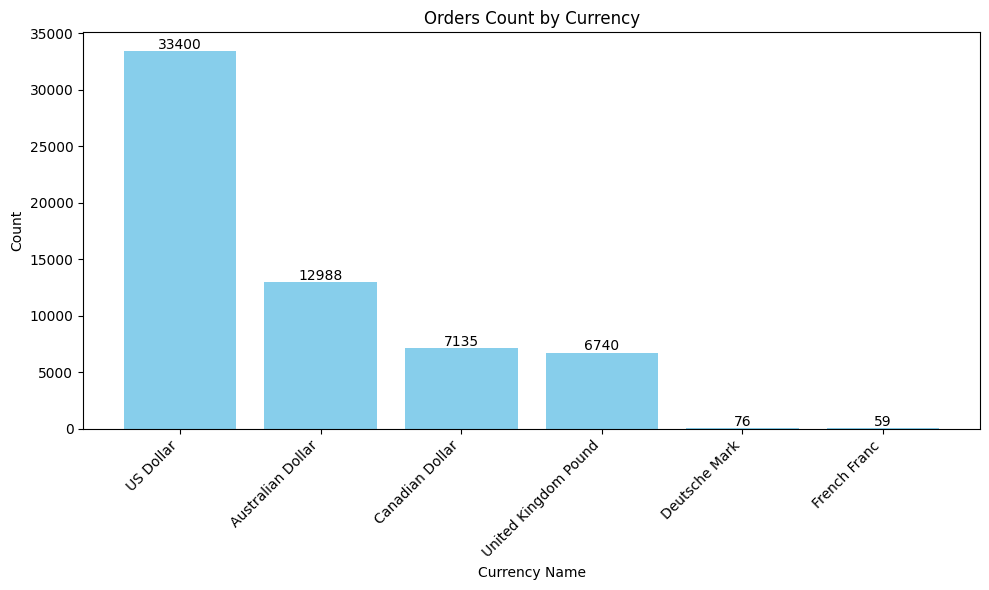

In [26]:
# Plot Currency_transaction_count
plt.figure(figsize=(10, 6))
bars = plt.bar(currency_transaction_count['CurrencyName'], currency_transaction_count['count'], color='skyblue')
plt.xlabel('Currency Name')
plt.ylabel('Count')
plt.title('Orders Count by Currency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
for bar, count in zip(bars, currency_transaction_count['count']):
    plt.text(bar.get_x() + bar.get_width() / 2 , bar.get_height() + 200, str(count), fontsize=10, ha='center')

plt.tight_layout()

# Display the plot
plt.show()

In [27]:
# Count orders by sales territory
sales_territory_count=merged_df['SalesTerritoryCountry'].value_counts().to_frame().reset_index()

In [28]:
sales_territory_count

SalesTerritoryCountry  count
0         United States  21344
1             Australia  13345
2                Canada   7620
3        United Kingdom   6906
4               Germany   5625
5                France   5558

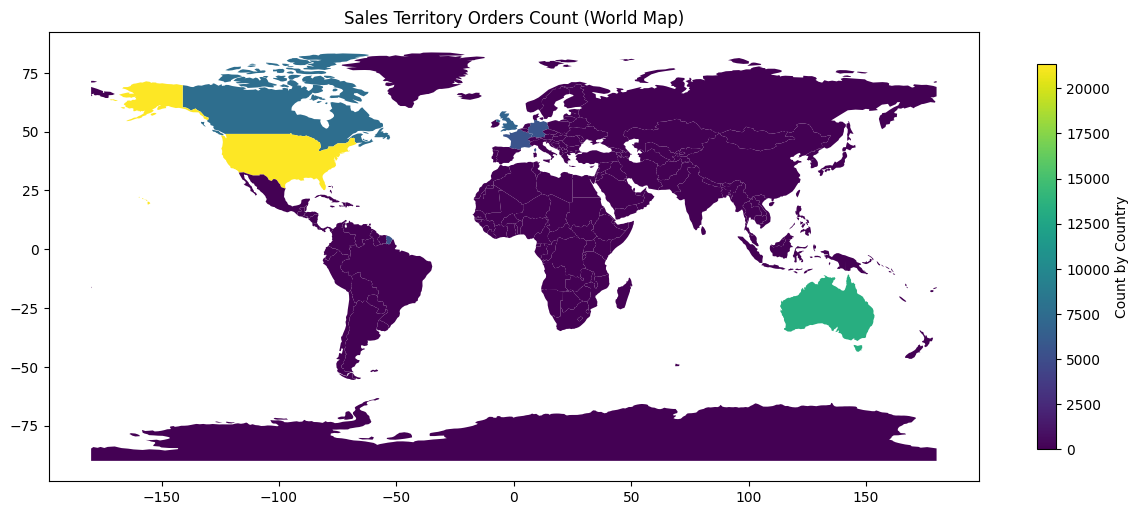

In [29]:
# Plot on World Map
world = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
world['name'] = world['name'].replace({'United States of America': 'United States'})
world.drop(columns=['pop_est','continent','iso_a3','gdp_md_est'],inplace=True)
merged_sales_territory = world.merge(sales_territory_count, left_on='name', right_on='SalesTerritoryCountry', how='left')

# Setting the count for countries not in the dataframe to NaN
merged_sales_territory['count'].fillna(0, inplace=True)

# Plotting the world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_kwds = {'label': "Count by Country", 'orientation': "vertical", 'shrink': 0.5}

merged_sales_territory.plot(column='count', ax=ax, legend=True, cmap='viridis',
                            missing_kwds={'color': 'white', 'edgecolor': 'black'},
                            legend_kwds=legend_kwds)

plt.title("Sales Territory Orders Count (World Map)")
plt.show()

In [30]:
# Most ordered Products
products_orders_count=merged_df['EnglishProductName'].value_counts().to_frame().reset_index().head(10)

In [31]:
products_orders_count

EnglishProductName  count
0    Water Bottle - 30 oz.   4244
1      Patch Kit/8 Patches   3191
2       Mountain Tire Tube   3095
3           Road Tire Tube   2376
4    Sport-100 Helmet, Red   2230
5             AWC Logo Cap   2190
6   Sport-100 Helmet, Blue   2125
7    Fender Set - Mountain   2121
8  Sport-100 Helmet, Black   2085
9     Mountain Bottle Cage   2025

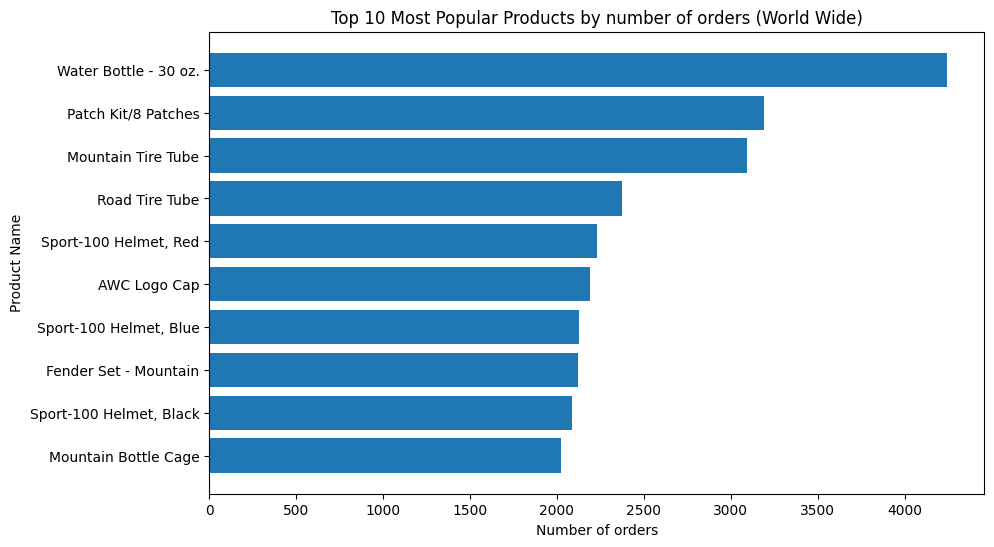

In [32]:
# Horizontal Bar plot of most ordered Products
plt.figure(figsize=(10, 6))
plt.barh(products_orders_count['EnglishProductName'], products_orders_count['count'])
plt.xlabel('Number of orders')
plt.ylabel('Product Name')
plt.title('Top 10 Most Popular Products by number of orders (World Wide)')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

In [33]:
# Check if there are more that 1 order quantity
list(merged_df['OrderQuantity'].unique())

[1]

In [34]:
# drop order quantity col
merged_df.drop(['OrderQuantity'],axis=1,inplace=True)

In [35]:
customers_orders_count=merged_df['FullName'].value_counts().to_frame().reset_index().head(10)

In [36]:
customers_orders_count

FullName  count
0  Ashley Henderson     68
1   Fernando Barnes     67
2   Charles Jackson     65
3  Jennifer Simmons     63
4      Henry Garcia     62
5     Mason Roberts     60
6      Dalton Perez     59
7        April Shan     58
8  Samantha Jenkins     58
9     Nancy Chapman     57

In [37]:
# Count Genter 
genders=merged_df['Gender'].value_counts().to_frame().reset_index()

In [38]:
genders

Gender  count
0      M  30381
1      F  30017

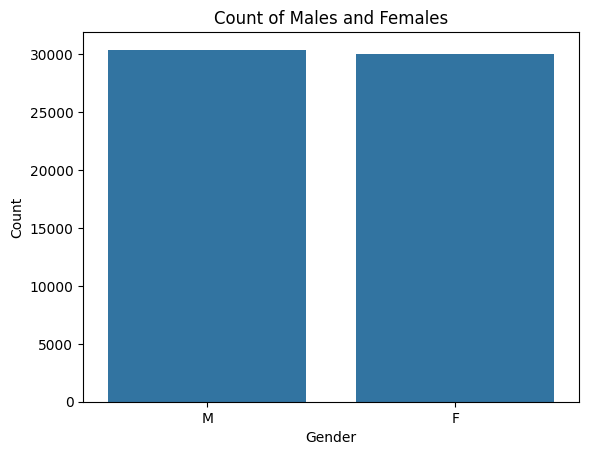

In [39]:
# Gender Bar plot
sns.barplot(x='Gender', y='count', data=genders)

# Adding labels and title for clarity
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Males and Females')

# Display the plot
plt.show()

In [40]:
#Groupby education /occupation
grouped_education_occupation = merged_df.groupby(['EnglishEducation', 'EnglishOccupation']).size().reset_index(name='counts')

In [41]:
grouped_education_occupation

EnglishEducation EnglishOccupation  counts
0             Bachelors          Clerical    2277
1             Bachelors        Management    5458
2             Bachelors            Manual     233
3             Bachelors      Professional    6755
4             Bachelors    Skilled Manual    3421
5       Graduate Degree          Clerical    1713
6       Graduate Degree        Management    3569
7       Graduate Degree            Manual     174
8       Graduate Degree      Professional    2750
9       Graduate Degree    Skilled Manual    2397
10          High School          Clerical     197
11          High School        Management    1163
12          High School            Manual    2567
13          High School      Professional    3183
14          High School    Skilled Manual    3210
15      Partial College          Clerical    4103
16      Partial College        Management     323
17      Partial College            Manual    2275
18      Partial College      Professional    5744
19      Partial College    Skilled Manual    4178
20  Partial High School          Clerical    1334
21  Partial High School        Management      81
22  Partial High School            Manual    1675
23  Partial High School      Professional     563
24  Partial High School    Skilled Manual    1055

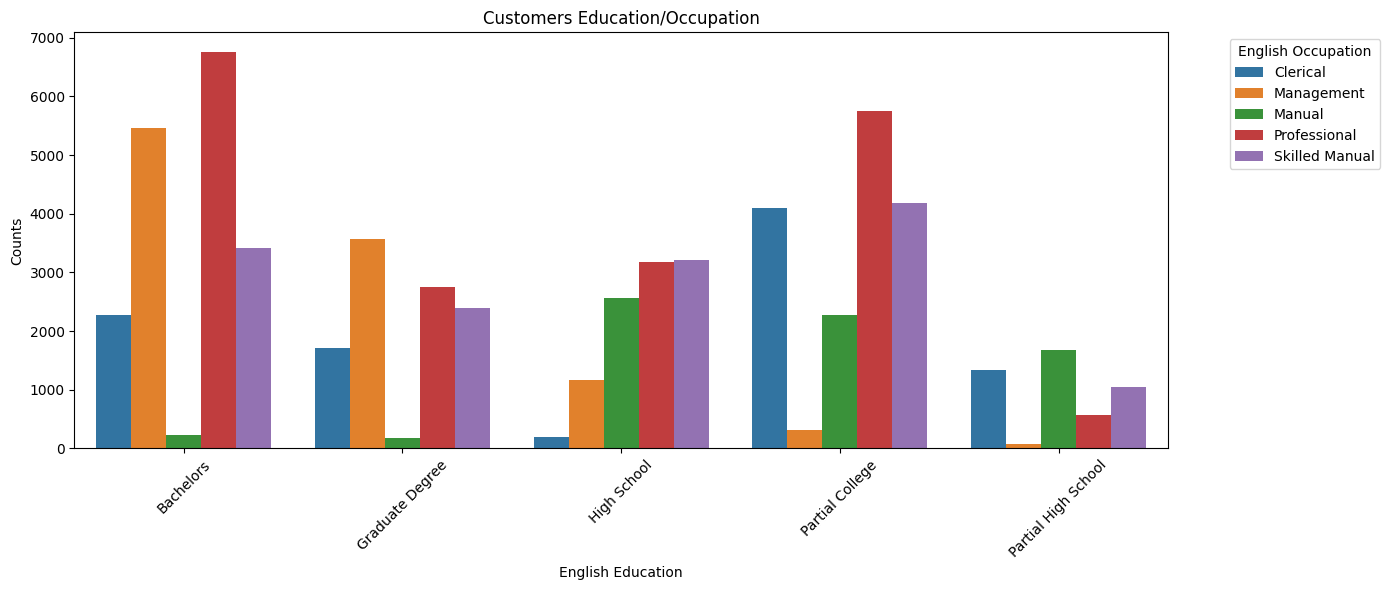

In [42]:
# Plot Education Occupation
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='EnglishEducation', y='counts', hue='EnglishOccupation', data=grouped_education_occupation, palette='tab10')
plt.title('Customers Education/Occupation')
plt.xlabel('English Education')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='English Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [43]:
# Count orders by year
order_yearly_counts = merged_df["OrderDate"].dt.year.value_counts().reset_index().sort_values(by='OrderDate')

In [44]:
# change the datetime to int
order_yearly_counts['OrderDate'] = order_yearly_counts['OrderDate'].astype(int)

In [45]:
order_yearly_counts

OrderDate  count
4       2010     14
2       2011   2216
1       2012   3397
0       2013  52801
3       2014   1970

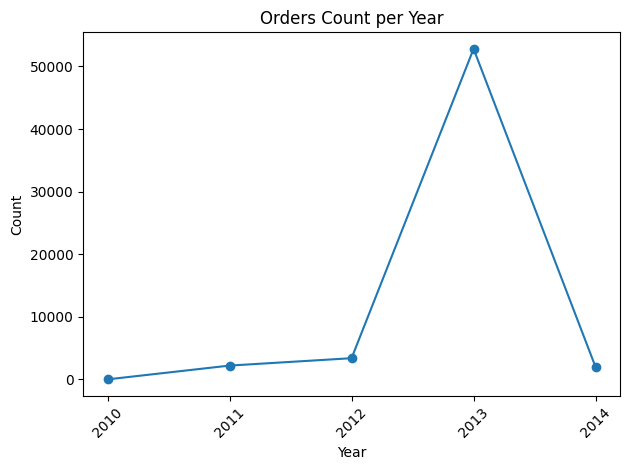

In [46]:
# Linechart of orders per year
order_dates = order_yearly_counts['OrderDate']
count_values = order_yearly_counts['count']

fig, ax = plt.subplots()
ax.plot(order_dates, count_values, marker='o', linestyle='-')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Orders Count per Year')

# Show only integer values on the x-axis
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# RFM Analysis and clustering Kmeans

In [47]:
# since most orders are in us dollars filter df and keep only us dollar records

In [48]:
#keep only us dollars orders
merged_df_us_dollars = merged_df[merged_df['CurrencyName'].isin(['US Dollar'])]

# merged_df_us_dollars.describe()
merged_df_us_dollars.isnull().values.any()
#Examine number of transactions per customer 
customer_counts = merged_df_us_dollars["FullName"].value_counts().sort_values(ascending=False).reset_index()
product_sales = merged_df_us_dollars.groupby(['EnglishProductName'])['SalesAmount'].agg('sum').sort_values(ascending=False).reset_index()
product_sales_top_10=product_sales.head(10)
product_sales_top_10_plot = product_sales_top_10.iloc[::-1]
fig = px.bar(product_sales_top_10_plot, 
             x='SalesAmount', 
             y='EnglishProductName', 
             orientation='h', 
             color='SalesAmount',
             color_continuous_scale=px.colors.sequential.YlGnBu,
            template="plotly_white",
            width=1000,
          height=700 )
fig.update_layout(
title_text='Top 10 Product Sales (Us Dollars)',
title_font_size=20,
# title_font_family="Open Sans",
title_x=0.5,
xaxis_title="Sales Amount",
yaxis_title="Product Name",

)
fig.show()
# pio.write_image(fig, "test.png")
customer_counts_top_10=customer_counts.head(10)
customer_counts_top_10_plot=customer_counts_top_10.iloc[::-1]
fig = px.bar(customer_counts_top_10_plot, 
             x='count', 
             y='FullName', 
             orientation='h', 
             color='count',
             color_continuous_scale=px.colors.sequential.OrRd,
            template="plotly_white",
            width=1000,
          height=500 )
fig.update_layout(
title_text="Customers that have most orders (Us Dollars)",
title_font_size=20,
# title_font_family="Open Sans",
title_x=0.5,
xaxis_title="Orders Count",
yaxis_title="Customers",

)
fig.show()
# pio.write_image(fig, "test.png")

## Create RFM Dataframe

### Frequency : Frequency of customers by counting order number of each customer, the more the count the more often the customer buys

### Recency : Recency, is calculated by subtracting the very recent date with the last transaction date of the customers.

### Monetary : Calculating monetary by summing up all the amounts of each customer

In [49]:
merged_df_us_dollars['Recency'] = (merged_df_us_dollars['OrderDate'].max() - merged_df_us_dollars['OrderDate']).dt.days
rfm = merged_df_us_dollars.groupby(["CustomerKey"]).agg({'Recency': np.min,
                                      'OrderDate': pd.Series.nunique,
                                     'SalesAmount': np.sum}).reset_index()


#Rename columns
rfm.rename(columns={'Recency':'Recency','OrderDate':'Frequency','SalesAmount':'Monetary'},inplace= True)
rfm

CustomerKey  Recency  Frequency   Monetary
0            11012      105          2    81.2600
1            11013        7          2   113.9600
2            11014      273          2   138.4500
3            11015      375          1  2500.9700
4            11016      353          1  2332.2800
...            ...      ...        ...        ...
11813        29476      922          1  3399.9900
11814        29479      511          1  2049.0982
11815        29481      899          1  3374.9900
11816        29482      497          1  2049.0982
11817        29483      506          1  2049.0982

[11818 rows x 4 columns]

In [50]:
#plot box plots

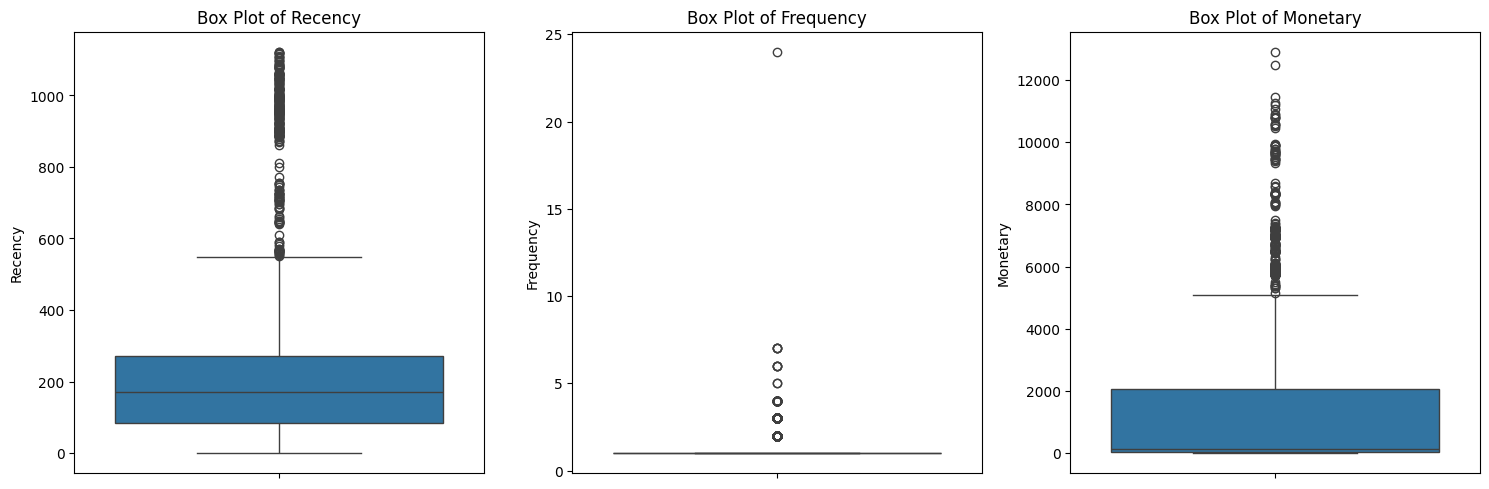

In [51]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=rfm["Recency"])
plt.title("Box Plot of Recency")

plt.subplot(1, 3, 2)
sns.boxplot(y=rfm["Frequency"])
plt.title("Box Plot of Frequency")

plt.subplot(1, 3, 3)
sns.boxplot(y=rfm["Monetary"])
plt.title("Box Plot of Monetary")

plt.tight_layout()
plt.show()

In [52]:
#Use Stanard scaler to scale the data

In [53]:
ss=StandardScaler()
X_prescaled=rfm[['Recency', 'Frequency', 'Monetary']]
X_scaled = ss.fit_transform(X_prescaled)

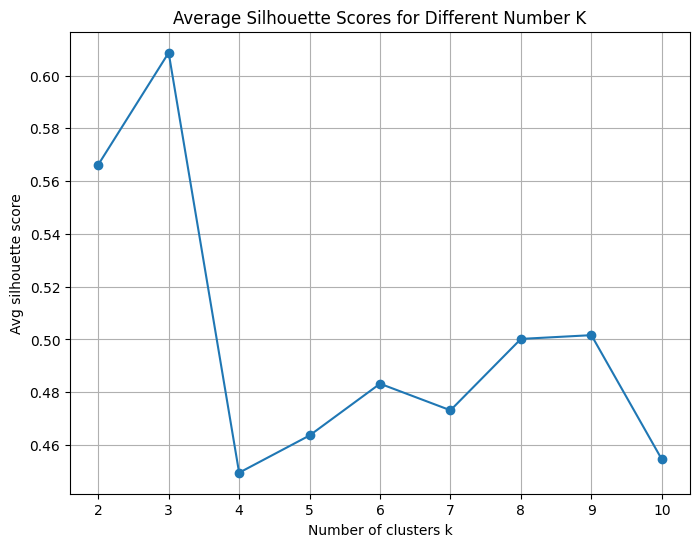

In [54]:
silhouette_avg_scores=avg_silhouette_scores(X_scaled,k_range=range(2,11),n_init=10,max_iter=50,random_state=0)
plot_avg_silhouette_scores(k_range=range(2,11),scores=silhouette_avg_scores)

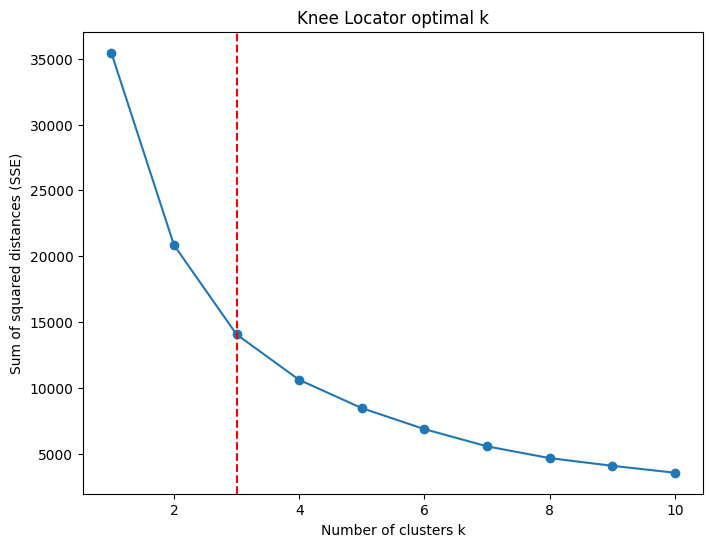

In [55]:
sse=sse_calculation(X_scaled,k_range=range(1,11),n_init=10,max_iter=50,random_state=0)
plot_kneelocator(sse_list=sse,k_range=range(1,11),curve='convex',direction='decreasing')

In [56]:
kmeans=KMeans(n_clusters=3,max_iter=50,random_state=0,n_init=10)
kmeans.fit(X_scaled)

KMeans(max_iter=50, n_clusters=3, n_init=10, random_state=0)

In [57]:
# normalized=pd.DataFrame(X_scaled)
# normalized.columns = ['Recency', 'Frequency', 'Monetary']
# normalized.loc[:,'CustomerKey']=rfm['CustomerKey']
# normalized['cluster']=kmeans.labels_
# labels=kmeans.labels_
# centroids = kmeans.cluster_centers_

In [58]:
kmeans = KMeans(n_clusters=3, random_state=0,max_iter=50,n_init=10)
clusters = kmeans.fit_predict(X_scaled)
rfm['cluster']=clusters

<Axes: xlabel='cluster', ylabel='Monetary'>

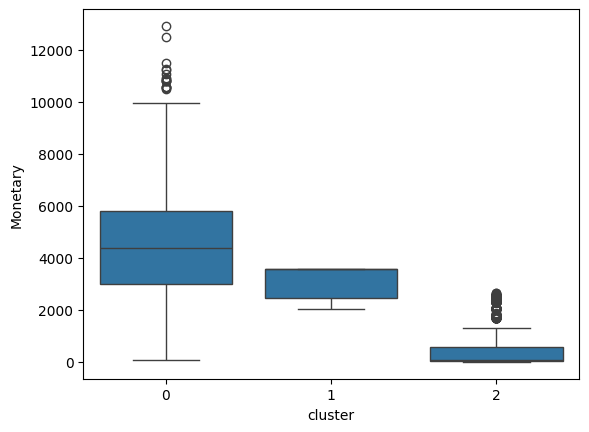

In [59]:
sns.boxplot(x='cluster',y='Monetary',data=rfm)

<Axes: xlabel='cluster', ylabel='Frequency'>

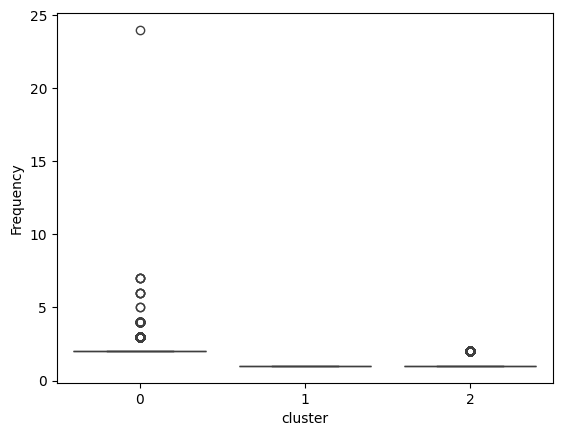

In [60]:
sns.boxplot(x='cluster',y='Frequency',data=rfm)

<Axes: xlabel='cluster', ylabel='Recency'>

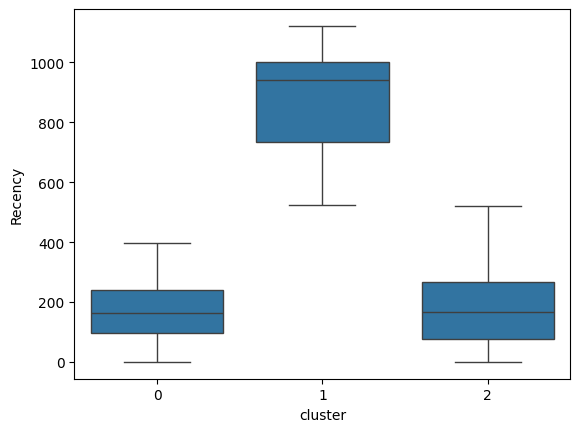

In [61]:
sns.boxplot(x='cluster',y='Recency',data=rfm)

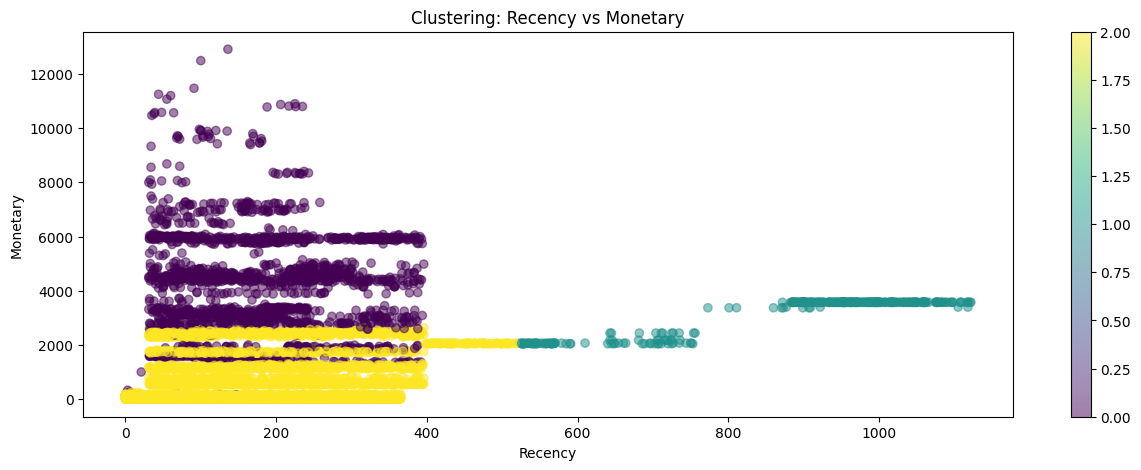

In [62]:
# Plot
plt.figure(figsize=(15, 5))
plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustering: Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.colorbar()  # Show color scale
plt.show()

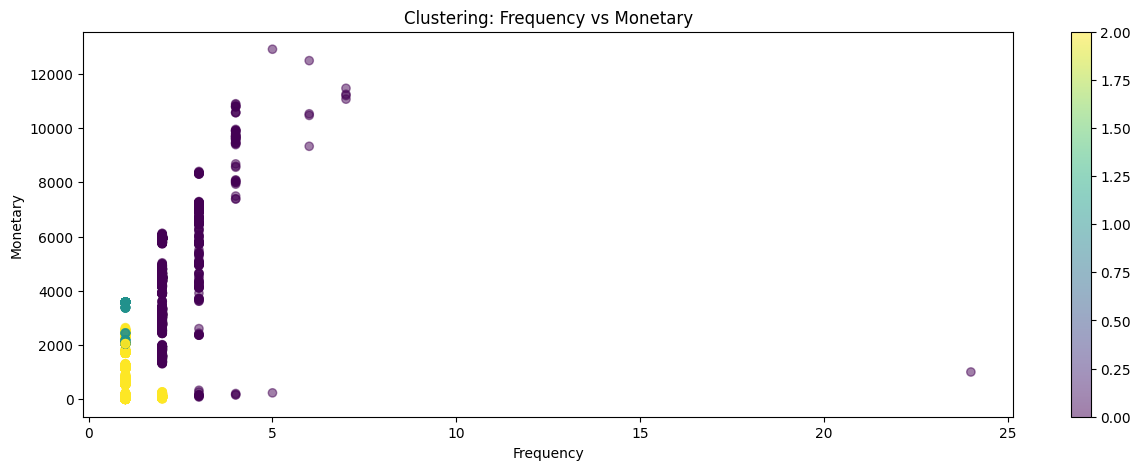

In [63]:
# Plot
plt.figure(figsize=(15, 5))
plt.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustering: Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.colorbar()  # Show color scale
plt.show()

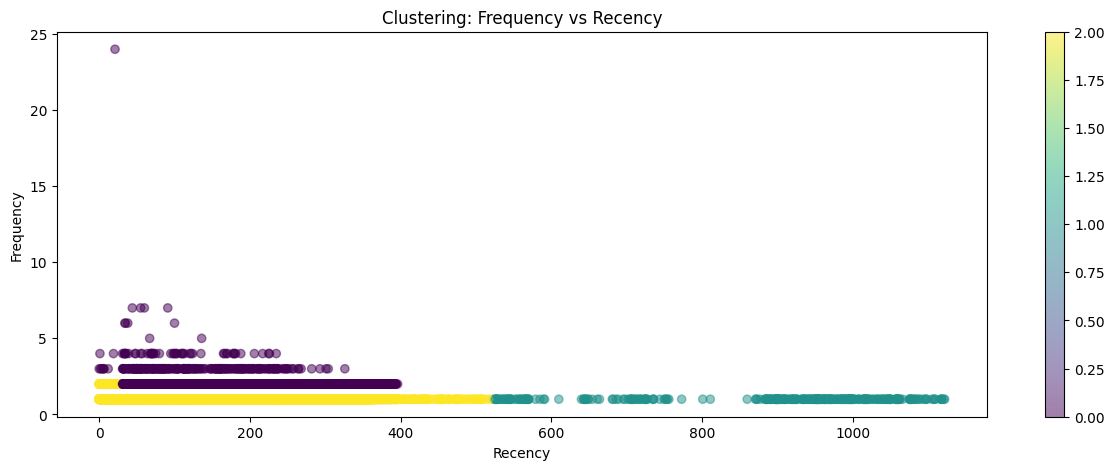

In [64]:
# Plot
plt.figure(figsize=(15, 5))
plt.scatter(rfm['Recency'], rfm['Frequency'], c=rfm['cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustering: Frequency vs Recency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.colorbar()  # Show color scale
plt.show()

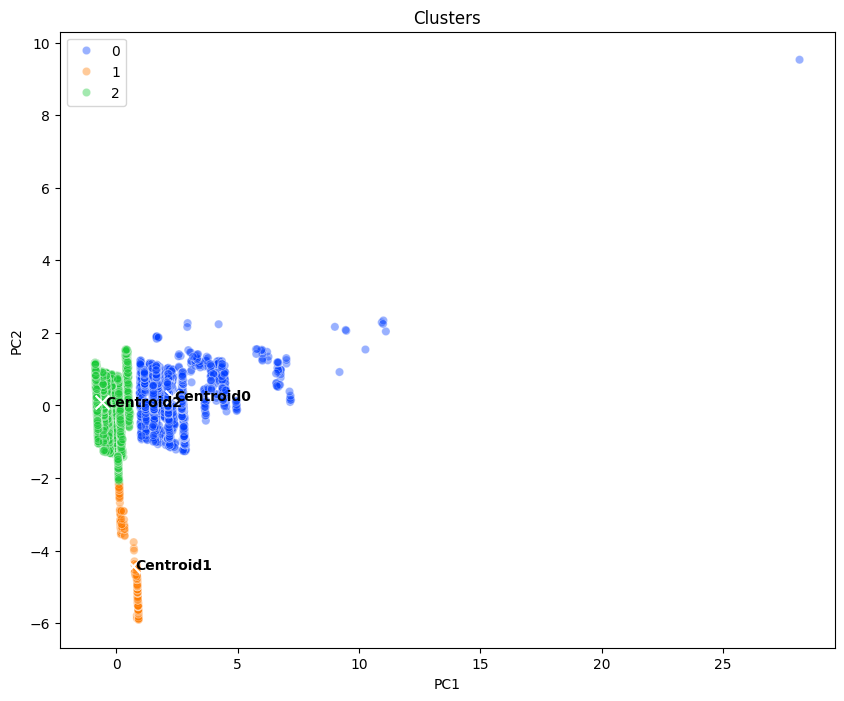

In [65]:
# Reducing the dimensions to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Creating a DataFrame with the two principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
centroids = pca.transform(kmeans.cluster_centers_)
# Setting up colors for each cluster
palette = sns.color_palette("bright", n_colors=len(kmeans.cluster_centers_))

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette=palette, alpha=0.4)

# Plotting the centroids and placing bold labels with padding to the right
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], color='white', marker='x', s=100)
    plt.text(centroid[0] + 0.1, centroid[1], f'Centroid{i}', color='black', ha='left', va='center', fontweight='bold')

plt.title('Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# plt.savefig('clusters_plot.png', dpi=300)
plt.show()

# Clustering Customers Kmeans

In [66]:
# Keep 2013 records and us dollar records
merged_df_2013 = merged_df[(merged_df['OrderDate'].dt.year == 2013) & (merged_df['CurrencyName'] == 'US Dollar')]
merged_df_2013_filtered=merged_df_2013[['CustomerKey','SalesAmount','MaritalStatus', 'Gender','YearlyIncome', 'TotalChildren','EnglishEducation', 'EnglishOccupation']]
merged_df_2013_filtered.reset_index(drop=True,inplace=True)
kmeans_df=merged_df_2013_filtered.copy()
num_cols = kmeans_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = kmeans_df.select_dtypes(include=['object']).columns
# Convert categorical data to numerical
le = LabelEncoder()
kmeans_df[cat_cols] = kmeans_df[cat_cols].apply(lambda col: le.fit_transform(col))

In [67]:
##Standard scaler Try
scaler = StandardScaler()
scaled_data_standard_scaler = scaler.fit_transform(kmeans_df)

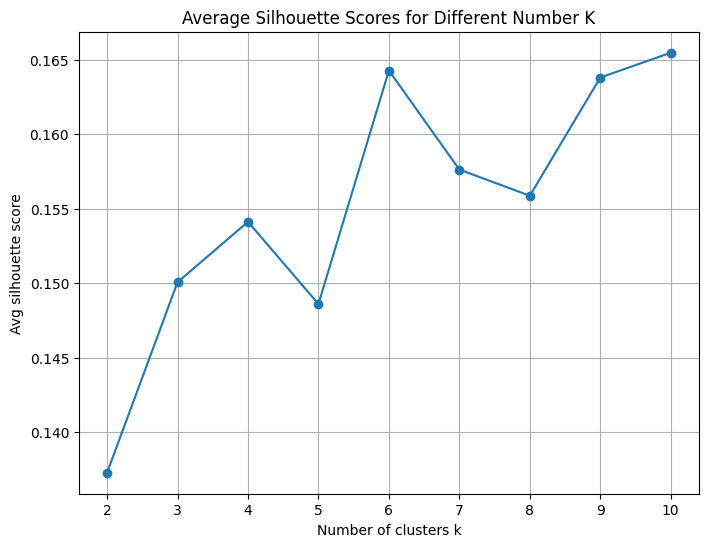

In [68]:
silhouette_avg_scores=avg_silhouette_scores(scaled_data_standard_scaler,k_range=range(2,11),n_init=10,max_iter=50,random_state=0)
plot_avg_silhouette_scores(k_range=range(2,11),scores=silhouette_avg_scores)

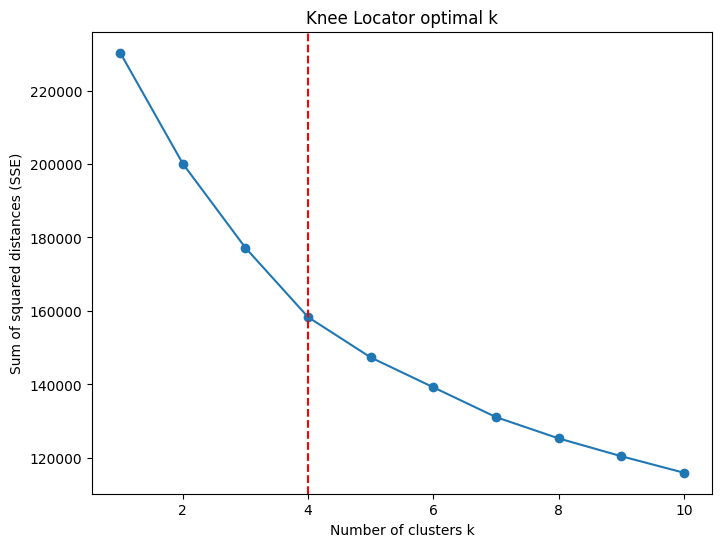

In [69]:
sse=sse_calculation(scaled_data_standard_scaler,k_range=range(1,11),n_init=10,max_iter=50,random_state=0)
plot_kneelocator(sse_list=sse,k_range=range(1,11),curve='convex',direction='decreasing')

In [70]:
kmeans = KMeans(n_clusters=4, random_state=0,max_iter=50,n_init=10)
clusters = kmeans.fit_predict(scaled_data_standard_scaler)
kmeans_df['Cluster']=clusters
merged_df_2013_filtered['Cluster']=clusters

In [71]:
kmeans_df['Cluster'].value_counts()

Cluster
2    9598
1    8862
0    7468
3    2858
Name: count, dtype: int64

In [72]:
average_income_by_cluster = merged_df_2013_filtered.groupby('Cluster')['YearlyIncome'].mean()
sum_SalesAmound_by_cluster = merged_df_2013_filtered.groupby('Cluster')['SalesAmount'].sum()

In [73]:
average_income_by_cluster

Cluster
0    26144.884842
1    84957.120289
2    53898.728902
3    68358.992302
Name: YearlyIncome, dtype: float64

In [74]:
sum_SalesAmound_by_cluster

Cluster
0     866054.33
1     515577.57
2    1068506.97
3    6352551.20
Name: SalesAmount, dtype: float64

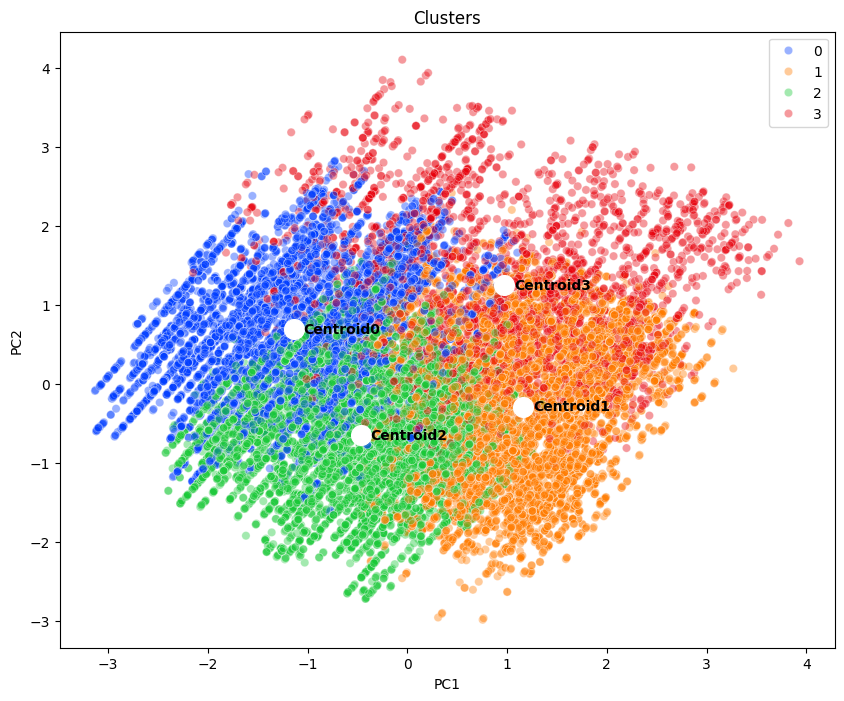

In [75]:
# Reducing the dimensions to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data_standard_scaler)

# Creating a DataFrame with the two principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
centroids = pca.transform(kmeans.cluster_centers_)
# Setting up colors for each cluster
palette = sns.color_palette("bright", n_colors=len(kmeans.cluster_centers_))

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette=palette, alpha=0.4)

# Plotting the centroids and placing bold labels with padding to the right
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], color='white', marker='o', s=200)
    plt.text(centroid[0] + 0.1, centroid[1], f'Centroid{i}', color='black', ha='left', va='center', fontweight='bold')

plt.title('Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
# Save the figure BEFORE plt.show()
# plt.savefig('clusters_plot.png', dpi=300)
plt.show()

In [76]:
merged_df_2013 = merged_df[(merged_df['OrderDate'].dt.year == 2013) & (merged_df['CurrencyName'] == 'US Dollar')]
merged_df_2013_filtered=merged_df_2013[['CustomerKey','SalesAmount','MaritalStatus', 'Gender','YearlyIncome', 'TotalChildren','EnglishEducation', 'EnglishOccupation']]
merged_df_2013_filtered.reset_index(drop=True,inplace=True)
kmeans_df=merged_df_2013_filtered.copy()
num_cols = kmeans_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = kmeans_df.select_dtypes(include=['object']).columns
# Convert categorical data to numerical
le = LabelEncoder()
kmeans_df[cat_cols] = kmeans_df[cat_cols].apply(lambda col: le.fit_transform(col))

In [77]:
# Quantile Scaler
quantile_scaler = QuantileTransformer(output_distribution='normal')
scaled_data_quantile_scaler = quantile_scaler.fit_transform(kmeans_df)

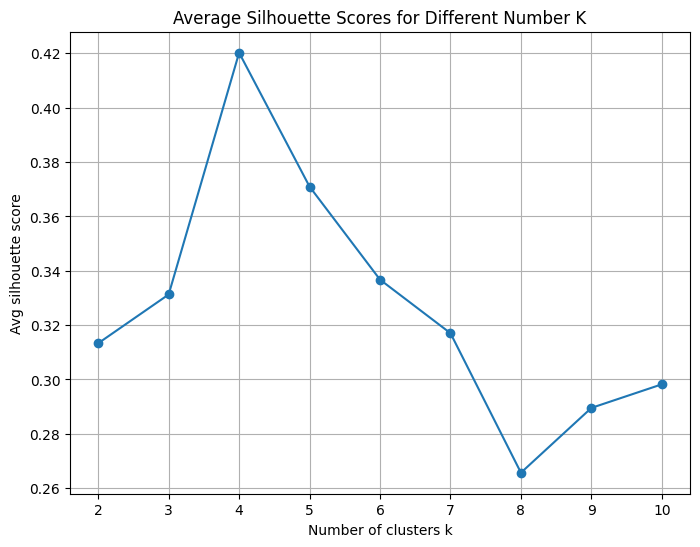

In [78]:
silhouette_avg_scores=avg_silhouette_scores(scaled_data_quantile_scaler,k_range=range(2,11),n_init=10,max_iter=50,random_state=0)
plot_avg_silhouette_scores(k_range=range(2,11),scores=silhouette_avg_scores)

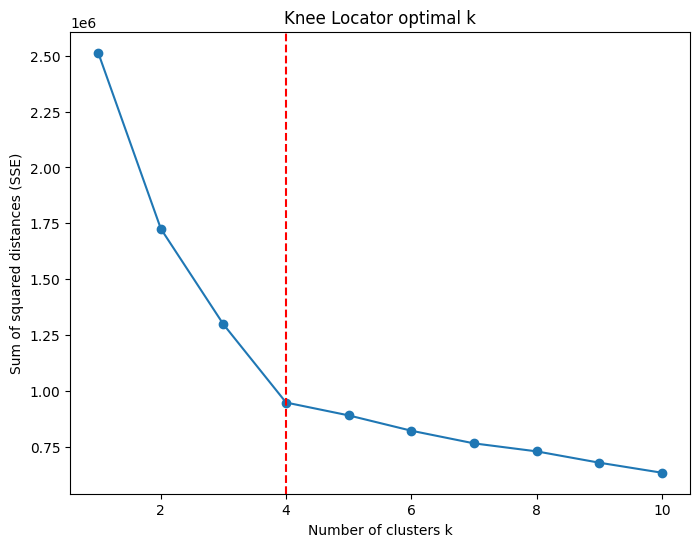

In [79]:
sse=sse_calculation(scaled_data_quantile_scaler,k_range=range(1,11),n_init=10,max_iter=50,random_state=0)
plot_kneelocator(sse_list=sse,k_range=range(1,11),curve='convex',direction='decreasing')

In [80]:
kmeans = KMeans(n_clusters=4, random_state=0,max_iter=50,n_init=10)
clusters = kmeans.fit_predict(scaled_data_quantile_scaler)
kmeans_df['Cluster']=clusters
merged_df_2013_filtered['Cluster']=clusters

In [81]:
kmeans_df['Cluster'].value_counts()

Cluster
0    8241
3    7602
1    6766
2    6177
Name: count, dtype: int64

In [82]:
average_income_by_cluster = merged_df_2013_filtered.groupby('Cluster')['YearlyIncome'].mean()
sum_SalesAmound_by_cluster = merged_df_2013_filtered.groupby('Cluster')['SalesAmount'].sum()

In [83]:
average_income_by_cluster

Cluster
0    61702.463293
1    53768.844221
2    52619.394528
3    60972.112602
Name: YearlyIncome, dtype: float64

In [84]:
sum_SalesAmound_by_cluster

Cluster
0    2485491.60
1    2100547.56
2    1852450.92
3    2364199.99
Name: SalesAmount, dtype: float64

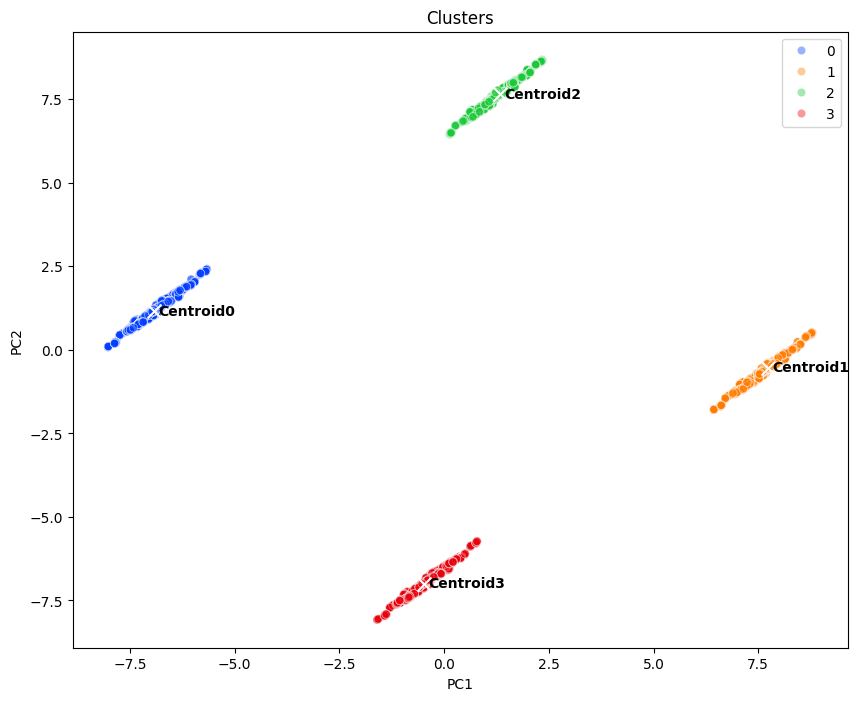

In [85]:
# Reducing the dimensions to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data_quantile_scaler)

# Creating a DataFrame with the two principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
centroids = pca.transform(kmeans.cluster_centers_)
# Setting up colors for each cluster
palette = sns.color_palette("bright", n_colors=len(kmeans.cluster_centers_))

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette=palette, alpha=0.4)

# Plotting the centroids and placing bold labels with padding to the right
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], color='white', marker='x', s=100)
    plt.text(centroid[0] + 0.1, centroid[1], f'Centroid{i}', color='black', ha='left', va='center', fontweight='bold')

plt.title('Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
# Save the figure BEFORE plt.show()
# plt.savefig('clusters_plot.png', dpi=300)
plt.show()

In [86]:
# conda env create -n new_env_name -f environment.yml
